# Plot Figures 7 (maps), 8 (boxplots), 9 (hour), 10 (GPS)


In [1]:


import h5py
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from obspy import read
from matplotlib import cm
import matplotlib.gridspec as gridspec
import os
import datetime as dtt
import matplotlib.patches
import matplotlib.patches as mpatches
import matplotlib.dates as mdates
import datetime
from  sklearn.preprocessing import StandardScaler
import sys
from matplotlib.patches import Rectangle
import sklearn.metrics
from scipy import spatial
import matplotlib.image as mpimg
import obspy
from scipy.signal import butter, lfilter
import librosa
from scipy.io import loadmat
from sklearn.decomposition import PCA
import scipy.io as spio
from sklearn.metrics import silhouette_samples
import seaborn as sns
import scipy as sp
import scipy.io as spio
import scipy.signal
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report

from obspy.signal.cross_correlation import correlate, xcorr_max


sys.path.append('.')
sys.path.append('./functions/')

import paths
from sklearn.cluster import KMeans
# import figureFunctions


##CUSTOM LEGEND
from matplotlib.patches import Patch
from matplotlib.lines import Line2D


from functions2 import getFeatures, getLocationFeatures,getNMFOrder,resortByNMF,getSpectra_fromWF,getSgram,getFP
from functions2 import PCAonFP,calcSilhScore,getDailyTempDiff,getSpectraMedian,CalcDiffPeak,PVEofPCA,getTopFCat 
from functions2 import catMergeFromH5, swapLabels, calcFFT, getWF, swapLabels,trimSpectra, KMeansSpectra, compileSpectraFromWF
import figureFunctions2


from functions2 import getFeatures, getLocationFeatures,getNMFOrder,resortByNMF,getSpectra_fromWF,getSgram,catMergeFromH5,lagWF,calcCorr_template
from functions2 import PCAonFP,calcSilhScore,getDailyTempDiff,getSpectraMedian,CalcDiffPeak,PVEofPCA,getTopFCat, calcCorr_template, calcCCMatrix

from functions2 import getSpectra,getFP,getMaxIndexFP,calcFFT, getWF, swapLabels,trimSpectra, KMeansSpectra, compileSpectraFromWF, lagWF


## Set paths

In [2]:
#%% load project variables: names and paths
# key = sys.argv[1]

# key = "BB_Gorner_Event_Final_v11_J8"
key = "BB_Gorner_Event_Redo_v2"
# keyN = "BB_Gorner_Cont_Final_v10_J8"
keyN = "BB_Gorner_Cont_Redo_v5"

filetype = '.gse2'     
filetypeN = '.sac' 


p = paths.returnp(key)
pN = paths.returnp(keyN)

#%%

projName        = p['projName']
datasetID       = p['datasetID']
projName        = p['projName']
station         = p['station']
channel         = p['channel']
path_top        = p['path_top']
path_proj       = p['path_proj']
outfile_name    = p['outfile_name']
dataFile_name   = p['dataFile_name']
path_WF         = p['path_WF']
path_Cat        = p['path_Cat'] #original, raw catalog
subCatalog_Name = f"{dataFile_name}_Sgrams_Subcatalog.hdf5"



pathFP          = f'{path_top}{projName}/03_output/{station}/SpecUFEx_output/step4_FEATout/'
pathACM         = f'{path_top}{projName}/03_output/{station}/SpecUFEx_output/step2_NMF/'
pathSTM         = f'{path_top}{projName}/03_output/{station}/SpecUFEx_output/step4_stateTransMats/'
pathEB          = f'{path_top}{projName}/02_src/02_SpecUFEx/EB.mat'
pathElnB          = f'{path_top}{projName}/02_src/02_SpecUFEx/ElnB.mat'
pathW        = path_proj + '02_src/02_SpecUFEx/out.DictGain.mat' 


# pathClusCat = path_proj + f"principalDf_full_{mode}_Kopt{Kopt}.csv"
dataH5_path = path_proj + dataFile_name


projNameN        = pN['projName']
datasetIDN       = pN['datasetID']
projNameN        = pN['projName']
station         = pN['station']
channel         = pN['channel']


path_top        = pN['path_top']
path_projN       = pN['path_proj']
outfile_nameN    = pN['outfile_name']
dataFile_nameN   = pN['dataFile_name']
path_WFN         = pN['path_WF']
path_CatN        = pN['path_Cat'] #original, raw catalog
subCatalog_NameN = f"{dataFile_name}_Sgrams_Subcatalog.hdf5"


pathACMN         = f'{path_top}{projNameN}/03_output/{station}/SpecUFEx_output/step2_NMF/'
pathSTMN         = f'{path_top}{projNameN}/03_output/{station}/SpecUFEx_output/step4_stateTransMats/'
pathEBN          = f'{path_top}{projNameN}/02_src/02_SpecUFEx/EB.mat'
pathElnBN          = f'{path_top}{projNameN}/02_src/02_SpecUFEx/ElnB.mat'
pathWN        = path_projN + '02_src/02_SpecUFEx/out.DictGain.mat' 



# pathClusCatN = path_projN + f"principalDf_full_{mode}_Kopt{KoptN}.csv"
dataH5_pathN = path_projN + dataFile_nameN


pathFig = '../05_reports/figures/'
pathFigSupp = '../05_reports/supp_figures/'
pathAuxData = '../01_input/data/processed/Garcia/'

## Load auxiliary data

In [3]:
## Load auxiliary catalog

gps_station_list = ['24','34','36','37']
gps_df_list = []

for gst in gps_station_list:
    
    
    gps_df = pd.read_csv(f'{pathAuxData}gps_roll_Slopecorrected_{gst}.csv',index_col=0)
    gps_df['datetime'] = [pd.to_datetime(ii) for ii in gps_df.index]
    gps_df['datetime_index'] = [pd.to_datetime(ii) for ii in gps_df.index]
    gps_df = gps_df.set_index('datetime_index')
    
    
    gps_df_list.append(gps_df)


lake_df = pd.read_csv(f'{pathAuxData}lake_df.csv',index_col=0)
lake_df['datetime'] = [pd.to_datetime(ii) for ii in lake_df.index]
lake_df['datetime_index'] = [pd.to_datetime(ii) for ii in lake_df.index]
lake_df = lake_df.set_index('datetime_index')


meteor_df = pd.read_csv(f'{pathAuxData}meteor_df.csv',index_col=0)
meteor_df['datetime'] = [pd.to_datetime(ii) for ii in meteor_df.index]
meteor_df['datetime_index'] = [pd.to_datetime(ii) for ii in meteor_df.index]
meteor_df = meteor_df.set_index('datetime_index')

rain_df = meteor_df.rain


## Define some important times in study period

In [4]:
# timing of lake events 
tstart = dtt.datetime(2007, 6, 13)
tend = dtt.datetime(2007, 7, 23)
calvet = dtt.datetime(2007, 7, 1,13,41,35)
supraDraint = dtt.datetime(2007, 7, 4)
subDraint = dtt.datetime(2007, 7, 7)
drainEndt = dtt.datetime(2007, 7, 15)


## Load cluster catalogs

In [5]:
Kopt = 3
KoptN = 4

## # # we prefer to read the catalogs originally created  .... 
cat00 = pd.read_csv(f'../01_input/data/interim/{key}_icequakes_k{Kopt}.csv')
cat00N = pd.read_csv(f'../01_input/data/interim/{keyN}_noise_k{KoptN}.csv')

cat00['event_ID'] = [int(evv) for evv in cat00.event_ID]
cat00N['event_ID'] = [int(evv) for evv in cat00N.event_ID]



#why two the same?? not sure : / 
cat00['evID'] = [int(evv) for evv in cat00.evID]


cat00['datetime_index'] =  [pd.Timestamp(d) for d in cat00.datetime_index]
cat00.set_index('datetime_index',inplace=True)


cat00N['datetime_index'] =  [pd.Timestamp(d) for d in cat00N.datetime_index]
cat00N.set_index('datetime_index',inplace=True)


In [6]:
for k in range(1,Kopt+1):
    print(f'len cluster {k}:')
    print(len(cat00[cat00.Cluster==k]))

    
print('\n')
for k in range(1,KoptN+1):
    print(f'len cluster {k}:')
    print(len(cat00N[cat00N.Cluster==k]))

len cluster 1:
157
len cluster 2:
455
len cluster 3:
845


len cluster 1:
344
len cluster 2:
182
len cluster 3:
473
len cluster 4:
473


## Load station data

In [7]:
##station data 
stn = pd.read_csv("../01_input/data/raw/stnlst.csv",
                  header=None,
                  names=['name','X','Y','Elevation','dX','dY','Depth'])

        
     

## Get experiment parameters from H5 file

In [8]:
#########       #########       #########       #########       #########       #########       #########       #########       

####IQIQIQIQIQIQIQIQI

#########       #########       #########       #########       #########       #########       #########       #########       



with h5py.File(path_proj + dataFile_name,'r') as dataFile:

    lenData = dataFile['processing_info/'].get('lenData')[()]
    fs = dataFile['spec_parameters/'].get('fs')[()]
    
    # fmin = 
    nperseg = dataFile['spec_parameters/'].get('nperseg')[()]
    noverlap = dataFile['spec_parameters/'].get('noverlap')[()]
    nfft = dataFile['spec_parameters/'].get('nfft')[()]


    fmax = dataFile['spec_parameters/'].get('fmax')[()]
    fmax = np.ceil(fmax)
    fmin = dataFile['spec_parameters/'].get('fmin')[()]
    fmin = np.floor(fmin)    
    fSTFT = dataFile['spec_parameters/'].get('fSTFT')[()]
    tSTFT = dataFile['spec_parameters/'].get('tSTFT')[()]
    
    sgram_mode = dataFile['spec_parameters/'].get('mode')[()].decode('utf-8')
    scaling = dataFile['spec_parameters/'].get('scaling')[()].decode('utf-8')
    
    
fs = int(np.ceil(fs))
winLen_Sec = float(nperseg / fs)


#########       #########       #########       #########       #########       #########       #########       #########       

##### NOISENOISENOISENOISENOISE

#########       #########       #########       #########       #########       #########       #########       #########       


with h5py.File(path_projN + dataFile_nameN,'r') as dataFile:

    lenDataN = dataFile['processing_info/'].get('lenData')[()]
    fsN = dataFile['spec_parameters/'].get('fs')[()]
    
    # fminN = 
    npersegN = dataFile['spec_parameters/'].get('nperseg')[()]
    noverlapN = dataFile['spec_parameters/'].get('noverlap')[()]
    nfftN = dataFile['spec_parameters/'].get('nfft')[()]


    fmaxN = dataFile['spec_parameters/'].get('fmax')[()]
    fmaxN = np.ceil(fmaxN)
    fminN = dataFile['spec_parameters/'].get('fmin')[()]
    fminN = np.floor(fminN)    
    fSTFTN = dataFile['spec_parameters/'].get('fSTFT')[()]
    tSTFTN = dataFile['spec_parameters/'].get('tSTFT')[()]
    
    sgram_modeN = dataFile['spec_parameters/'].get('mode')[()].decode('utf-8')
    scalingN = dataFile['spec_parameters/'].get('scaling')[()].decode('utf-8')
    
    
fsN = int(np.ceil(fsN))
winLen_SecN = float(npersegN / fsN)



## Load specufex output

In [9]:

#########       #########       #########       #########       #########       #########       #########       #########       

## specufex output - IQIQIQIQIQIQIQIQIQIQ
 
#########       #########       #########       #########       #########       #########       #########       #########       Wmat = loadmat(pathW)

Wmat = loadmat(pathW)
EBmat = loadmat(pathEB)

W = Wmat.get('W1')
EB = EBmat.get('EB')



numPatterns = len(W[1])
Nfreqs = len(W)
numStates = EB.shape[0]



order_swap = getNMFOrder(W,numPatterns)
W_new = resortByNMF(W,order_swap)
EB_new = resortByNMF(EB,order_swap)

RMM = W_new @ EB_new.T

#########       #########       #########       #########       #########       #########       #########       #########       

## specufex output - NOISENOISENOINSENOISE

#########       #########       #########       #########       #########       #########       #########       #########       


WmatN = loadmat(pathWN)
EBmatN = loadmat(pathEBN)

WN = WmatN.get('W1')
EBN = EBmatN.get('EB')



numPatternsN = len(WN[1])
NfreqsN = len(WN)
numStatesN = EBN.shape[0]


order_swapN = getNMFOrder(WN,numPatternsN)
W_newN = resortByNMF(WN,order_swapN)
EB_newN = resortByNMF(EBN,order_swapN)

RMMN = W_newN @ EB_newN.T

## Format day ticks, time plotting

* Central European Time is 2 hours later than UTC (Coordinated Universal Time) 
* Max temp occurs around 16:00 (4pm) local time or, 14:00 (2pm) UTC
* All times in UTC


todo: fix ::


##dummy variable -- just needed to get complete day set -- FIXFIX
clus_clu_perday = cat0.event_ID.resample('D', label='left', closed='right').count()

In [10]:


############################################################
            ##### FORMAT DAY TICKS (ASSUMES NO DAYS SKIPPED?) ######
############################################################
tstart = pd.to_datetime('2007-06-14 00:00:00')
tend   = pd.to_datetime('2007-07-22 00:00:00')



delta_day = 7

##dummy variable -- just needed to get complete day set -- FIXFIX
clus_clu_perday = cat00.event_ID.resample('D', label='left', closed='right').count()

numDays = len(clus_clu_perday)

days_list = [clus_clu_perday.index[i] for i in range(numDays)]


## these have lots of possible text formats
day_labels = [f"{days_list[d].month}-{days_list[d].date().day}" for d in range(0,len(days_list),delta_day)]

day_ticks = [days_list[d] for d in range(0,len(days_list),delta_day)]


# Central European Time is 2 hours later than UTC (Coordinated Universal Time)
##max temp is around 4pm local time or 16:00, in UTC it is 14:00 or 2pm
## start of

#all times in UTC
hour_of_approx_max_temp = 14
# hourMaxTemp = [dtt.datetime(2007, 6, 14,hour_of_approx_max_temp,0,0) + pd.DateOffset(i) for i in range(0,numDays)]


## ts 2021/08/07 : change line to start of day
dayStart = hourMaxTemp = [dtt.datetime(2007, 6, 14) + pd.DateOffset(i) for i in range(0,numDays)]

hour24labels = [str(r) for r in range(0,24)] #UTC

print(day_labels)
############################################################
############################################################

       

['6-14', '6-21', '6-28', '7-5', '7-12', '7-19']


In [11]:
plt.rcParams['image.cmap']='magma'

plt.rcParams.update({'font.size': 8})
colors =cm.Paired(np.array([1,5,7,9,2,4,6,8]))


## when plotting, add a bit of buffer so bars aren't cut off
tlimstart = pd.to_datetime('2007-06-13 12:00:00')
tlimend   = pd.to_datetime('2007-07-22 12:00:00')


lw1=4        
lw2=5
alphaT=1
ylabfont=8
ylabpad =10


plt_kwargs = {'lw1':lw1,
              'lw2':lw2,
              'alphaT':alphaT,
              'ylabfont':ylabfont,
              'ylabpad':ylabpad,
              'colors':colors,
              'scaling':scaling,
              'sgram_mode':sgram_mode,
              'hour24labels':hour24labels,
              'day_ticks':day_ticks,
              'day_labels':day_labels,
              'numDays':numDays,
              'hourMaxTemp':hourMaxTemp,
              'tstart':tlimstart, ## for extending x axis to fit bars
              'tend':tlimend,     ## for extending x axis to fit bars
              'tstartreal':tstart,## actual study bound
              'tendreal':tend,     ## actual study bound
              'supraDraint':supraDraint,
              'subDraint':subDraint,
              'drainEndt':drainEndt}            


## Specs for figures JGR

In [12]:
#quarter page
width1 = 3.74016
height1 = 4.52756

#full page
width2 = 7.48031
height2 = 9.05512

# Figure 8

## Get Features for Rep Events


In [13]:
gF=1

df_loc = pd.read_csv(f'../01_input/data/interim/{key}_df_locALL.csv')
dfN = pd.read_csv(f'../01_input/data/interim/{key}_df_statALLN.csv')
df = pd.read_csv(f'../01_input/data/interim/{key}_df_statALL.csv')

# Figure 7 - Map of Icequakes

## Map plus distance boxplots

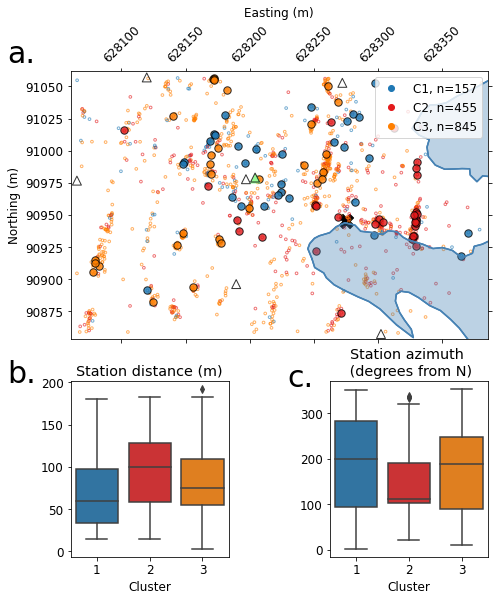

In [14]:
topF = 30
catRep = getTopFCat(cat00,topF)


##v3 separate map for each cluster
##settings for yellow bars
plotMap = 0
size1 = 1000
a1 = .7

k=3
plt.rcParams.update({'font.size': 12})


fig,axes = plt.subplots(figsize = (width2,height2))#,sharex=True,constrained_layout=True)


gs = gridspec.GridSpec(5,5)

ax = plt.subplot(gs[0:3,0:])
ax.set_aspect('equal')
ax.tick_params(axis='x',labelrotation=45)


ax.tick_params(labelbottom=False,labeltop=True)


## plot approximate moulin location

mx = 628275
my = 90945
ax.scatter(mx,my,marker='X',s=200,color='k',label='Moulin')


figureFunctions2.plotMap(cat00,
        ax=ax,
        colorBy='cluster',
        size=7,
        lw=1,
        alpha=.6,
        edgecolor='cluster',
        **plt_kwargs); 


figureFunctions2.plotMap(catRep,
        ax=ax,
        colorBy='cluster',
        size=55,
        marker='o',
        lw=1,
        alpha=.8,
        edgecolor='none',
        **plt_kwargs); 

ax.set_title('Easting (m)',fontsize=12)#,labelpad=8)

ax.set_ylabel('Northing (m)')
###% Stations
figureFunctions2.plotStations(stn,station,ax=ax)   
ax.tick_params(labelbottom=False,labeltop=True)



#%% Legend
from matplotlib.lines import Line2D
ms2 = 6
n_list = [len(cat00[cat00.Cluster==k]) for k in range(1,Kopt+1)]
legend_elements = [Line2D([0], [0], marker='o', linestyle='None', color=colors[0], label=f'C1, n={n_list[0]}',markersize=ms2),
                    Line2D([0], [0], marker='o', linestyle='None', color=colors[1], label=f'C2, n={n_list[1]}',markersize=ms2),
                    Line2D([0], [0], marker='o', linestyle='None', color=colors[2], label=f'C3, n={n_list[2]}',markersize=ms2)]
ax.legend(handles=legend_elements)#, loc='center')



#%% limits 
buff=5
ax.set_xlim(cat00.X_m.min()-buff,cat00.X_m.max()+buff)
ax.set_ylim(cat00.Y_m.min()-buff,cat00.Y_m.max()+buff)


ax.tick_params(bottom=True, top=True, left=True, right=True)
ax.tick_params(labelbottom=False, labeltop=True, labelleft=True, labelright=False)
ax.tick_params(labelbottom=False,labeltop=True)

ax2 = plt.subplot(gs[3:,0:2])
figureFunctions2.plotFeatureBoxPlot(df_loc,Kopt,'DistXYZ_m',ax=ax2,**plt_kwargs)
ax2.set_ylabel('')
ax2.set_title('Station distance (m)')




## plot full Depth boxplot
ax3 = plt.subplot(gs[3:,3:])
figureFunctions2.plotFeatureBoxPlot(df_loc,Kopt,'Azimuth',ax=ax3,**plt_kwargs)


ax3.set_ylabel('')
ax3.set_title('Station azimuth \n (degrees from N)')






ax2.text(-1.7,580,'a.',fontsize=30)
ax2.text(-1.7,200,'b.',fontsize=30)
ax3.text(-1.3,360,'c.',fontsize=30)

gs.update(hspace=0.5)


plt.savefig(pathFig + f'06_Locations.jpg', dpi=300, bbox_inches='tight')



# Figure 9 - Hourly clusters

## Stack hourly

./functions/functions2.py:392: FutureWarning: 'loffset' in .resample() and in Grouper() is deprecated.

>>> df.resample(freq="3s", loffset="8H")

becomes:

>>> from pandas.tseries.frequencies import to_offset
>>> df = df.resample(freq="3s").mean()
>>> df.index = df.index.to_timestamp() + to_offset("8H")

  temp_H = meteor_df1.temp.resample('H',loffset='30T').mean().ffill()
./functions/functions2.py:393: FutureWarning: 'loffset' in .resample() and in Grouper() is deprecated.

>>> df.resample(freq="3s", loffset="8H")

becomes:

>>> from pandas.tseries.frequencies import to_offset
>>> df = df.resample(freq="3s").mean()
>>> df.index = df.index.to_timestamp() + to_offset("8H")

  temp_D = meteor_df1.temp.resample('D',loffset='12H').mean().ffill()


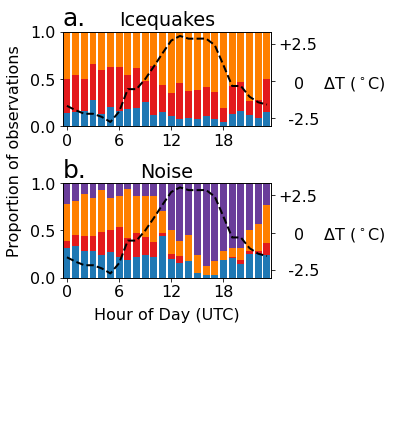

In [15]:
atext = 25 


plt.rcParams.update({'font.size': 16})
title = 'Icequakes'
titleN = 'Noise'
dailyTempDiff = getDailyTempDiff(meteor_df,**plt_kwargs)


tfont = 14
tpad = 16

fig,axes = plt.subplots(figsize = (width1,height1))#,sharex=True)#,constrained_layout=True)


gs = gridspec.GridSpec(2, 1)



### ICEQUAKE PROPORTION HOURLY
ax = plt.subplot(gs[0])
figureFunctions2.plotHourBarStack(cat00,Kopt,dailyTempDiff,ax=ax,labelpad=10,label='none',colorBy='cluster',**plt_kwargs)
ax.set_title('Icequakes',pad=8)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xlim(-.5,23.5)   
ax.set_ylim(0,1)
ax.set_title('a.',fontsize=atext,loc='left')

# ### NOISE PROPORTION HOURLY
axN = plt.subplot(gs[1])
figureFunctions2.plotHourBarStack(cat00N,KoptN,dailyTempDiff,ax=axN,labelpad=8,label='right',**plt_kwargs)
# axN.set_ylabel('')
axN.set_xlabel('')
axN.set_title('Noise',pad=8)
axN.set_ylabel('                               Proportion of observations',labelpad=8)
axN.set_xlim(-.5,23.5)
axN.set_ylim(0,1)
axN.set_xlabel('Hour of Day (UTC)',labelpad=8)
axN.set_title('b.',fontsize=atext,loc='left')

gs.update(hspace=.6)

plt.savefig(pathFig + f'08_hourlycluster.jpg', dpi=300, bbox_inches='tight')


# Figure 10 -  Clusters and GPS displacement over season

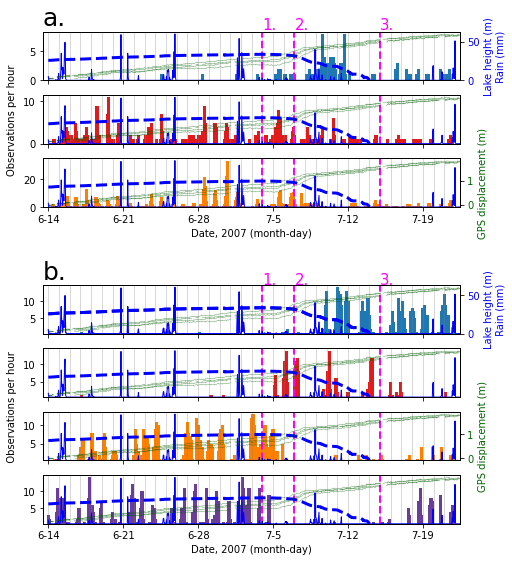

In [21]:
from matplotlib.ticker import FormatStrFormatter
plt.rcParams.update({'font.size': 10})
fig,axes = plt.subplots(figsize = (width2,height2))#,sharex=True)#,constrained_layout=True)



gs = gridspec.GridSpec(KoptN+Kopt+1,1)
gs.update(wspace=.6, hspace=.3)

tpad = 6


gpsstations = [24,34,36,37]

timecode = '3H'
datatype = ''


title = 'Icequakes'
textY = 16  
ymax = 8.7

texty = 15

for k in range(1,Kopt+1):
    
    ax=plt.subplot(gs[k-1,0])

    figureFunctions2.plotBarCluster(cat00,k=k,barWidth=.3,timeBin='H',ax=ax,**plt_kwargs)

    
    if k == 1:

        figureFunctions2.plotLake(lake_df,rain_df,legend=None,ylabel='right',ax=ax,**plt_kwargs)  
        
        ##title
        ax.set_title('Icequakes',fontsize=texty,loc='left')

        ax.text(x=supraDraint,y= ymax, s='1.',color='fuchsia',size=texty)
        ax.text(x=subDraint,y= ymax,s='2.',color='fuchsia',size=texty)
        ax.text(x=drainEndt,y= ymax,s='3.',color='fuchsia',size=texty)
   
        ax.set_title('a.',fontsize=atext,loc='left')

        for gps_dff in gps_df_list:
            figureFunctions2.plotGPS(gps_dff.gps_roll,ylabel='none',size=.1,ax=ax,**plt_kwargs)
    
    elif k==2:    
        ax.set_ylabel('Observations per hour',labelpad=6) 
        figureFunctions2.plotLake(lake_df,rain_df,legend=None,ylabel='none',ax=ax,**plt_kwargs)
        
        for gps_dff in gps_df_list:
            figureFunctions2.plotGPS(gps_dff.gps_roll,ylabel='none',size=.1,ax=ax,**plt_kwargs)
            
            
    elif k==3:
        for e, gps_dff in enumerate(gps_df_list):
            if e==0:
                figureFunctions2.plotGPS(gps_dff.gps_roll,ylabel='right',size=.1,ax=ax,**plt_kwargs)
            else:
                figureFunctions2.plotGPS(gps_dff.gps_roll,ylabel='none',size=.1,ax=ax,**plt_kwargs)
        figureFunctions2.plotLake(lake_df,rain_df,legend=None,ylabel='none',ax=ax,**plt_kwargs)
    
    else:
        figureFunctions2.plotLake(lake_df,rain_df,legend=None,ylabel='none',ax=ax,**plt_kwargs)
        for gps_dff in gps_df_list:
            figureFunctions2.plotGPS(gps_dff.gps_roll,ylabel='none',size=.1,ax=ax,**plt_kwargs)
            
    
    ax.axvline(x=subDraint,color='fuchsia',linestyle='--',linewidth=2, alpha=1)
    ax.axvline(x=supraDraint,color='fuchsia',linestyle='--',linewidth=2, alpha=1)   
    ax.axvline(x=drainEndt,color='fuchsia',ls='--',linewidth=2)


    if k == Kopt:
        ax.set_xlabel('Date, 2007 (month-day)')
        ax.tick_params(axis='x',labelrotation=0)
        
    else:
        ax.set_xlabel('')
        ax.set_xticklabels('')

        
        
ax=plt.subplot(gs[Kopt,0])
ax.axis('off')






titleN = 'Noise'
textYN = 17
# ymaxN = 18
ymaxN = 15

for k in range(1,KoptN+1):
    
    ax=plt.subplot(gs[k-1+Kopt+1,0])
#     ax.set_ylim(ymin=0)

    figureFunctions2.plotBarCluster(cat00N,k=k,barWidth=.3,timeBin='3H',ax=ax,**plt_kwargs)
    
    
    ax.axvline(x=subDraint,color='fuchsia',linestyle='--',linewidth=2, alpha=1)
    ax.axvline(x=supraDraint,color='fuchsia',linestyle='--',linewidth=2, alpha=1)   
    ax.axvline(x=drainEndt,color='fuchsia',ls='--',linewidth=2)
    
    
    if k == 1:
        ax.set_xlabel('')
        ax.set_xticklabels('')
        ax.set_title('b.',fontsize=atext,loc='left')

        figureFunctions2.plotLake(lake_df,rain_df,legend=None,ylabel='right',ax=ax,**plt_kwargs)

        
        
        ###TITLE
#         ax.text(x=datetime.datetime(2007,6,14),y= ymaxN, s='Noise',color='k',size=texty)
        
        ax.text(x=supraDraint,y= ymaxN, s='1.',color='fuchsia',size=texty)
        ax.text(x=subDraint,  y= ymaxN,s='2.',color='fuchsia',size=texty)
        ax.text(x=drainEndt,  y= ymaxN,s='3.',color='fuchsia',size=texty)
   
    if k == 3:

        ax.set_ylabel('                   Observations per hour',labelpad=6)  
        figureFunctions2.plotLake(lake_df,rain_df,legend=None,ylabel=None,ax=ax,**plt_kwargs)
        
        for e, gps_dff in enumerate(gps_df_list):
            if e==0:
                figureFunctions2.plotGPS(gps_dff.gps_roll,ylabel='right',size=.1,ax=ax,**plt_kwargs)
            else:
                figureFunctions2.plotGPS(gps_dff.gps_roll,ylabel='none',size=.1,ax=ax,**plt_kwargs)
    else:
        figureFunctions2.plotLake(lake_df,rain_df,legend=None,ylabel=None,ax=ax,**plt_kwargs)
        
        for gps_dff in gps_df_list:
            figureFunctions2.plotGPS(gps_dff.gps_roll,ylabel='none',size=.1,ax=ax,**plt_kwargs)

    if k == KoptN:
        ax.set_xlabel('Date, 2007 (month-day)')
        ax.tick_params(axis='x',labelrotation=0)
        
    else:
        ax.set_xlabel('')
        ax.set_xticklabels('')
    ax.set_ylim(bottom=.5)
    
        
plt.savefig(pathFig + f'07_clusterSeason.jpg', dpi=300, bbox_inches='tight')


